<a href="https://colab.research.google.com/github/MinHyeok-lee1/AICamera/blob/master/REAL_FINAL_TEST_128.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [378]:
# 필요한 라이브러리 다운로드
# 버전이 바뀌었을때 발생할 수 있는 오류들을 경고해주는 메시지
import warnings
#warnings.filterwarnings('always')
warnings.filterwarnings('ignore')
# System related and data input controls
import os
# Data manipulation and visualization
import pandas as pd
pd.options.display.float_format = '{:,.2f}'.format
pd.options.display.max_rows = 10
pd.options.display.max_columns = 20
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('ggplot')
# 한글 폰트 사용을 위해서 세팅
from matplotlib import font_manager, rc

import seaborn as sns

# Modeling algorithms
# General
import statsmodels.api as sm
from scipy import stats
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, layers, callbacks
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional

from datetime import datetime
from pylab import rcParams
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

import itertools
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
!pip install pmdarima
from pmdarima.arima import auto_arima

# Model selection
from sklearn.model_selection import train_test_split

from sklearn.datasets import load_breast_cancer
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score

from sklearn.preprocessing import MinMaxScaler, StandardScaler
# Evaluation metrics
# for regression
from sklearn.metrics import mean_squared_log_error, mean_squared_error,  r2_score, mean_absolute_error

In [379]:
# 1) Upload Data - Input Data
train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/train.csv', parse_dates=['date'])
test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/test.csv', parse_dates=['date'])

In [380]:
daily_sales = train.groupby('date', as_index=False)['sales'].sum()
store_daily_sales = train.groupby(['store', 'date'], as_index=False)['sales'].sum()
item_daily_sales = train.groupby(['item', 'date'], as_index=False)['sales'].sum()

Text(0, 0.5, 'Sales')

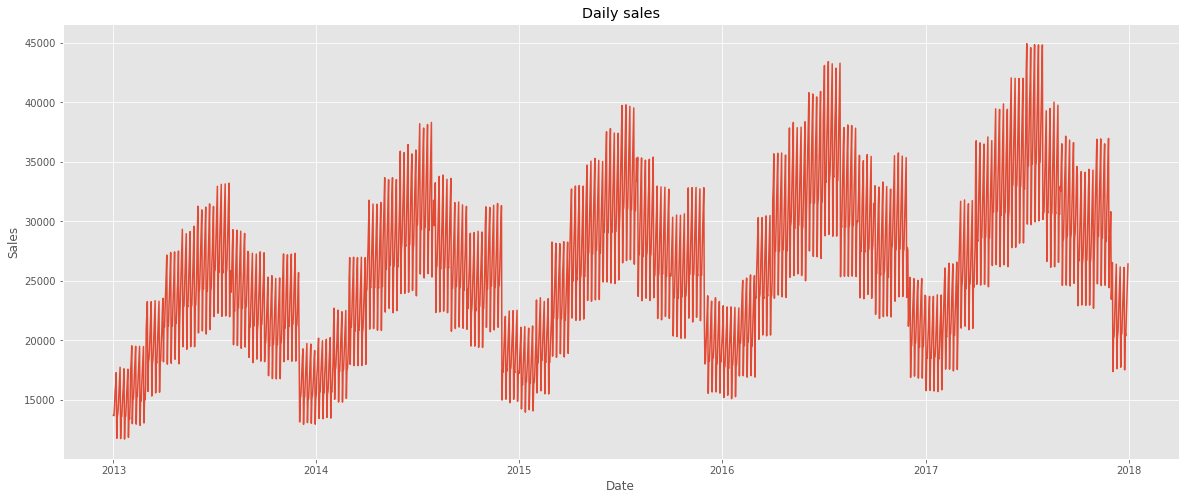

In [381]:
plt.figure(figsize=(20,8))
plt.plot(daily_sales['date'],daily_sales['sales'])
plt.title('Daily sales')
plt.xlabel('Date')
plt.ylabel('Sales')

Text(0, 0.5, 'Sales')

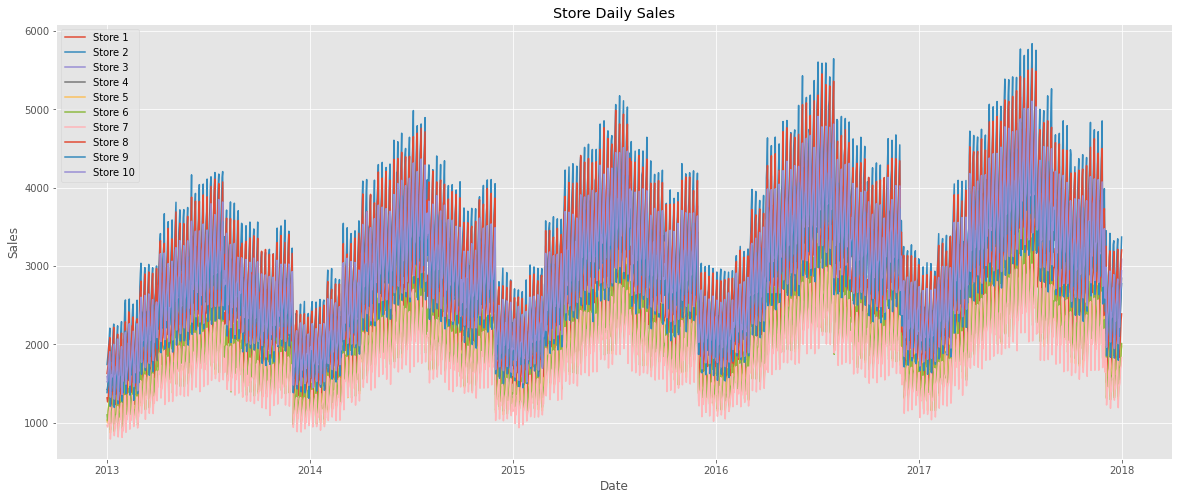

In [382]:
plt.figure(figsize=(20,8))

for i in range(1,11) :
    temp = store_daily_sales[store_daily_sales.store==i]
    plt.plot(temp['date'],temp['sales'], label = 'Store %d' % i)

plt.legend()
plt.title('Store Daily Sales')
plt.xlabel('Date')
plt.ylabel('Sales')

Text(0, 0.5, 'Sales')

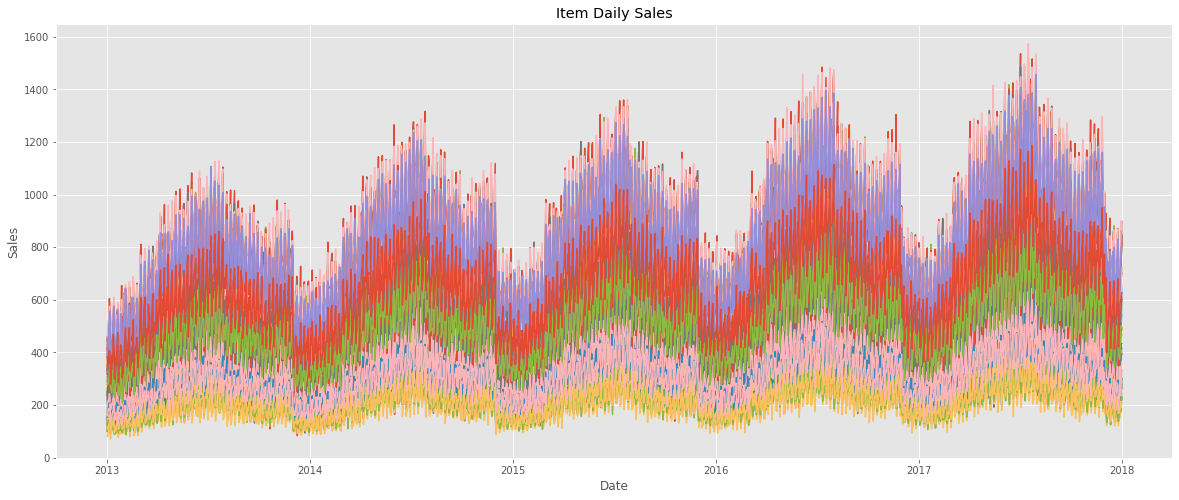

In [383]:
plt.figure(figsize=(20,8))

for i in range(1,51) :
    temp = item_daily_sales[item_daily_sales.item==i]
    plt.plot(temp['date'],temp['sales'], label = 'Item %d' %i)

# plt.legend()
plt.title('Item Daily Sales')
plt.xlabel('Date')
plt.ylabel('Sales')

In [384]:
# string 형태의 date 필드를 datetime 형태로 변환
train['date'] =  pd.to_datetime(train['date'])
df = train.set_index('date')

# 빠르게 테스트 해 보기 위해 월별로 아이템 판매 예측을 해 보기로 함
salesbymonth = df.drop(['store', 'item'], axis=1)
salesbymonth = salesbymonth.resample('M').sum()
# salesbymonth.groupby('date')[['sales']]
#2013-2016 데이터를 train으로 2017 데이터를 test로 분리
split = "2017-01-01"
salesbymonth_train= salesbymonth.loc[:split]
salesbymonth_test= salesbymonth.loc[split:]
salesbymonth_test_final=salesbymonth_test.copy()

train = train.set_index('date')
train_set= train.loc[:split]
test_set= train.loc[split:]
test_set_final=test_set.copy()

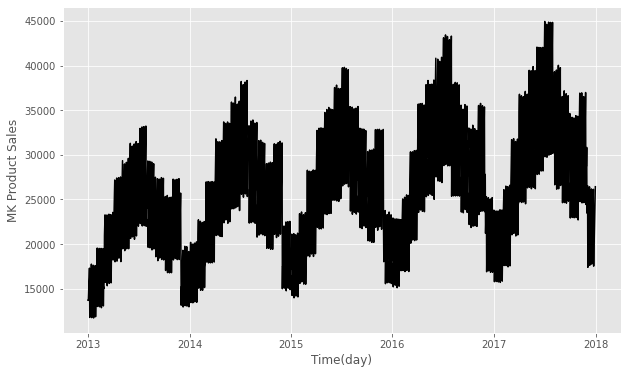

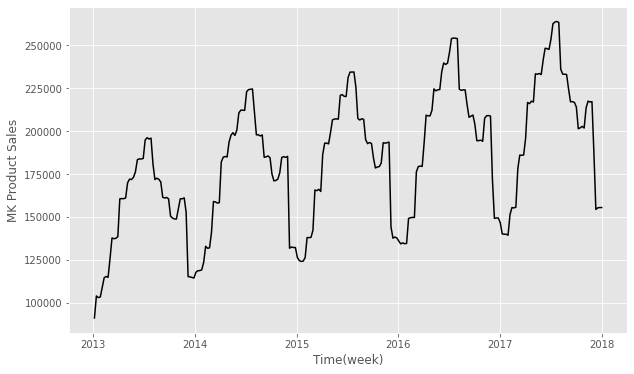

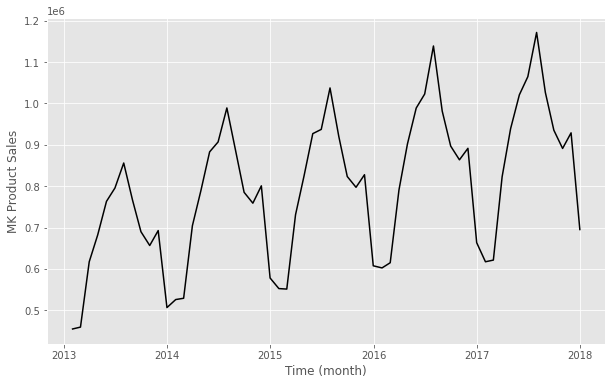

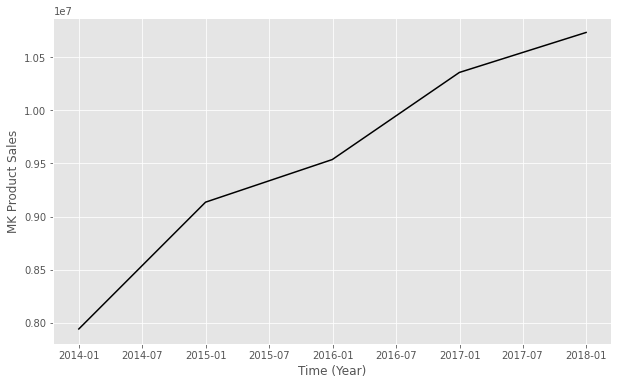

In [385]:
# 일, 주, 월, 년도 별 그래프 표시
def timeseries (x_axis, y_axis, x_label):
    plt.figure(figsize = (10, 6))
    plt.plot(x_axis, y_axis, color ='black')
    plt.xlabel(x_label, {'fontsize': 12}) 
    plt.ylabel('MK Product Sales', {'fontsize': 12})

# Graph by day, week, month
# 일별 그래프
df['day'] = df.index.day
train_by_day = df.resample('D').sum()
timeseries(train_by_day.index, train_by_day['sales'], 
           'Time(day)')

# 주별 그래프
df['week'] = df.index.week
train_by_week= df.resample('W').sum()
timeseries(train_by_week.index, train_by_week['sales'], 
           'Time(week)')

# 월별 그래프
df['month'] = df.index.month
train_by_year = df.resample('M').sum()
timeseries(train_by_year.index, train_by_year['sales'], 
           'Time (month)')

# 년도별 그래프
df['year'] = df.index.year
train_by_year = df.resample('Y').sum()
timeseries(train_by_year.index, train_by_year['sales'], 
           'Time (Year)')

In [386]:
#방법 1. p,d,q의 조합을 만들어 하나하나 ARIMA 모델을 돌려봄
p = d = q = range(0, 2)

import itertools
pdqa = list(itertools.product(p, d, q))

seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

for param in pdqa:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(salesbymonth_train, order=param, seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)                                
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue
            
#방법 2. auto_arima 함수로 자동 추출
from pmdarima import auto_arima
stepwise_model = auto_arima(salesbymonth_train, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1412.2229228457459
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:5516633.458516287
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:887.6565547548751
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:590.2742084017133
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:853.4883695710716
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1078.790120110935
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:580.0775060965184
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:526.6134096757977
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:1352.903523073248
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:5141891.975204614
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:839.3267866283813
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:541.8274398335935
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:1050.1679331711603
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:4885684.224247755
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:588.7594055535517
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:540.4312566499182
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:1196.0971642680395
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:94622.82225503924
ARIMA(0

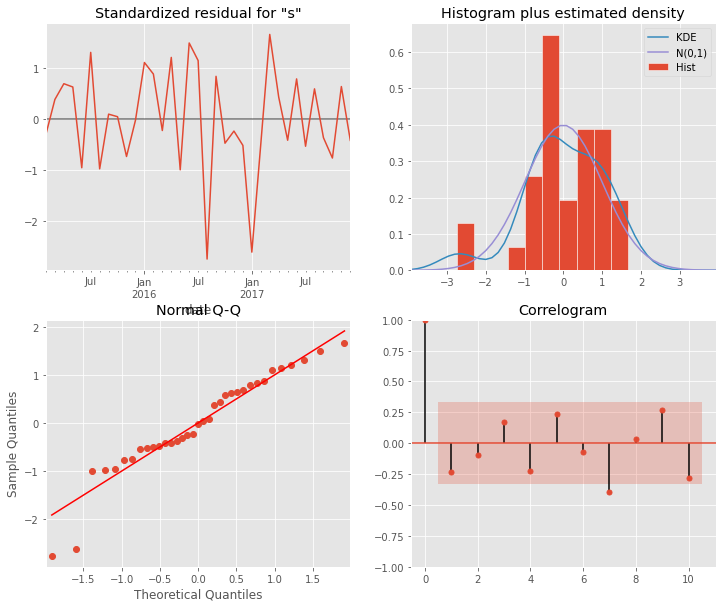

<Figure size 1296x576 with 0 Axes>

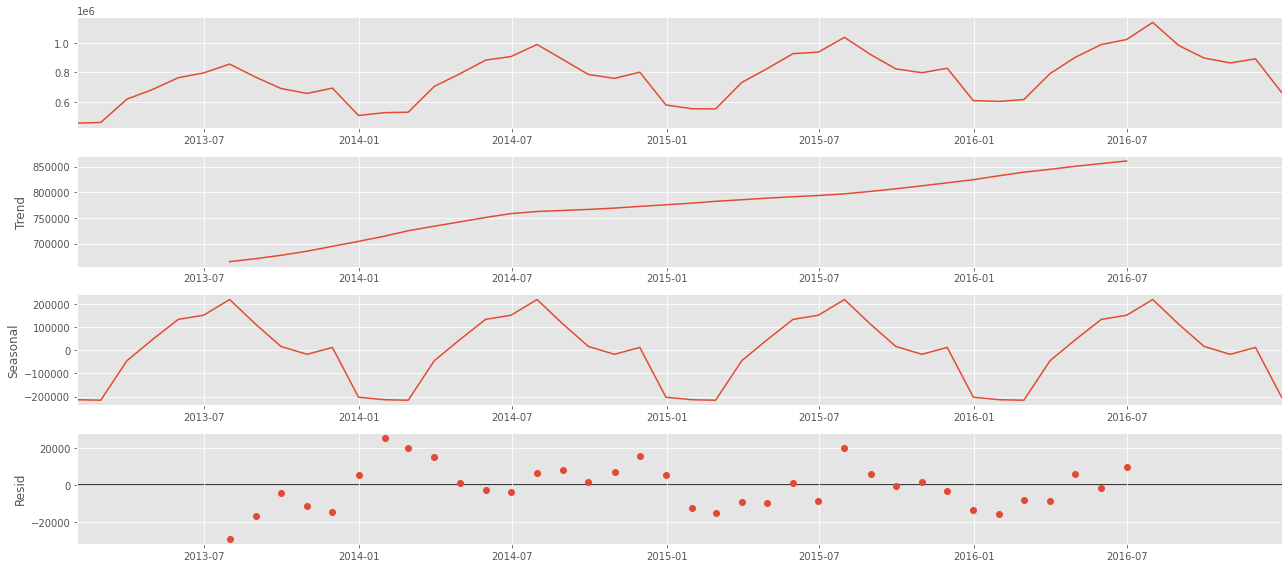

In [387]:
# 2) ARIMA
# 그래프에 대한 관측치, 추세, 계절성, 잔차 표시
SARIMAMonth = sm.tsa.statespace.SARIMAX(
    salesbymonth,
     order=(0, 1, 0),
      seasonal_order=(1, 1, 0, 12),
      enforce_stationarity=False,
      enforce_invertibility=False
      )

SARIMA_results_month = SARIMAMonth.fit()
SARIMA_results_month.plot_diagnostics(figsize=(12, 10))
plt.show()


plt.rcParams['figure.figsize'] = (18, 8)
result = sm.tsa.seasonal_decompose(salesbymonth_train,model='additive')
fig = plt.figure()
fig = result.plot()

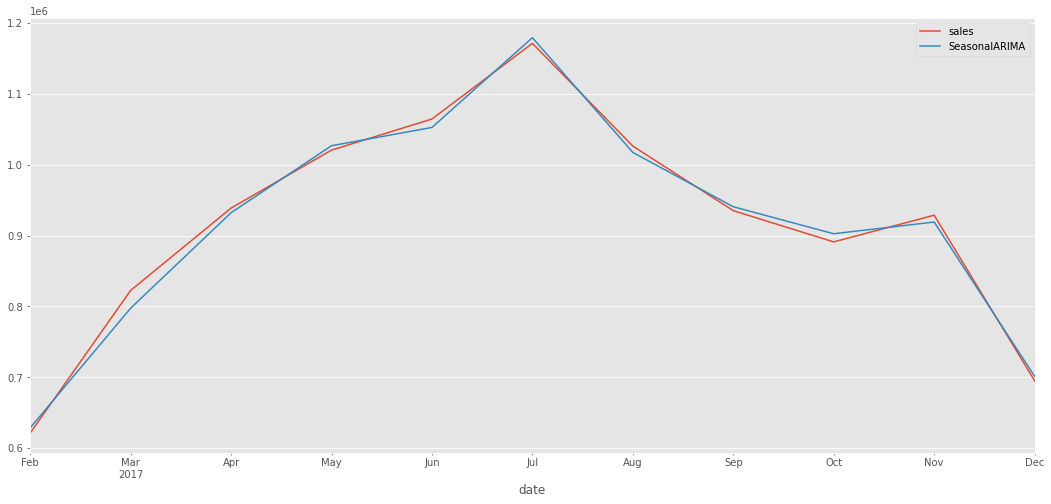

In [388]:
# 2017년 12개월 데이터로 예측
SARIMA_predict_month_1 = SARIMA_results_month.predict(start=48,end=60)

# 결과 비교를 위해 기존에 마련해둔 test데이터에 결과를 붙임
salesbymonth_test_final['SeasonalARIMA'] = SARIMA_predict_month_1

# test 데이터와 예측 결과치를 비교
salesbymonth_test_final[1:].plot()

[07:10:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:1642.44
Will train until validation_0-rmse hasn't improved in 20 rounds.
[1]	validation_0-rmse:1511.85
[2]	validation_0-rmse:1397.02
[3]	validation_0-rmse:1296.29
[4]	validation_0-rmse:1208.12
[5]	validation_0-rmse:1128.02
[6]	validation_0-rmse:1060.59
[7]	validation_0-rmse:1001.14
[8]	validation_0-rmse:950.948
[9]	validation_0-rmse:907.323
[10]	validation_0-rmse:866.123
[11]	validation_0-rmse:829.991
[12]	validation_0-rmse:800.454
[13]	validation_0-rmse:773.864
[14]	validation_0-rmse:753.497
[15]	validation_0-rmse:733.389
[16]	validation_0-rmse:717.843
[17]	validation_0-rmse:703.834
[18]	validation_0-rmse:688.98
[19]	validation_0-rmse:677.553
[20]	validation_0-rmse:666.913
[21]	validation_0-rmse:655.847
[22]	validation_0-rmse:648.25
[23]	validation_0-rmse:639.14
[24]	validation_0-rmse:633.701
[25]	validation_0-rmse:627.06
[26]	validation_

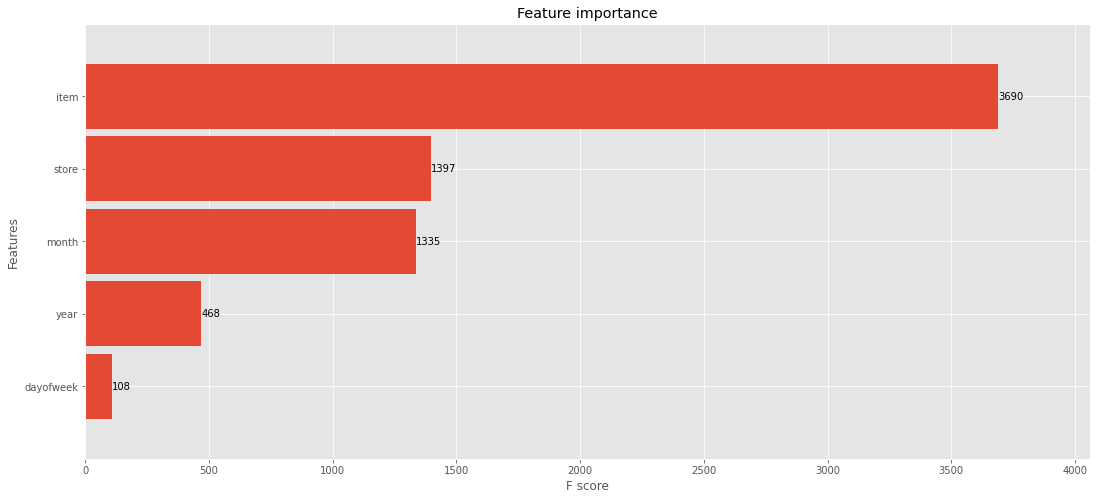

In [389]:
# Xgboost
# store / item 별로 월별 판매를 합산
df = df.groupby(['store', 'item'])['sales'].resample('M').sum()
df = df.reset_index()
df = df.set_index('date')

df['month'] = df.index.month
df['year'] = df.index.year
df['dayofweek'] = df.index.dayofweek

#2013-2016 데이터를 train으로 2017 데이터를 test로 분리
split = "2017-01-01"
train_data= df.loc[:split]
test_data= df.loc[split:]

# y값은 판매량, 나머지 항목들로 x값을 구성
Xgboost_train_y = df.loc[:,'sales']
Xgboost_train_x = df.drop('sales', axis=1)
Xgboost_test_y = df.loc[:,'sales']
Xgboost_test_x = df.drop('sales', axis=1)

# 추후에 예측값과 비교하기 위해 test 데이터 복제본 저장
Xgboost_test_orig = test_data.loc[:, ['store', 'item', 'sales']]

XG_model_month = xgb.XGBRegressor(n_estimators=1000)
XG_model_month.fit(Xgboost_train_x, Xgboost_train_y, eval_set=[(Xgboost_test_x, Xgboost_test_y)], early_stopping_rounds=20,verbose=True)

# 주요하게 적용하는 변수를 판단
plot_importance(XG_model_month, height=0.9)

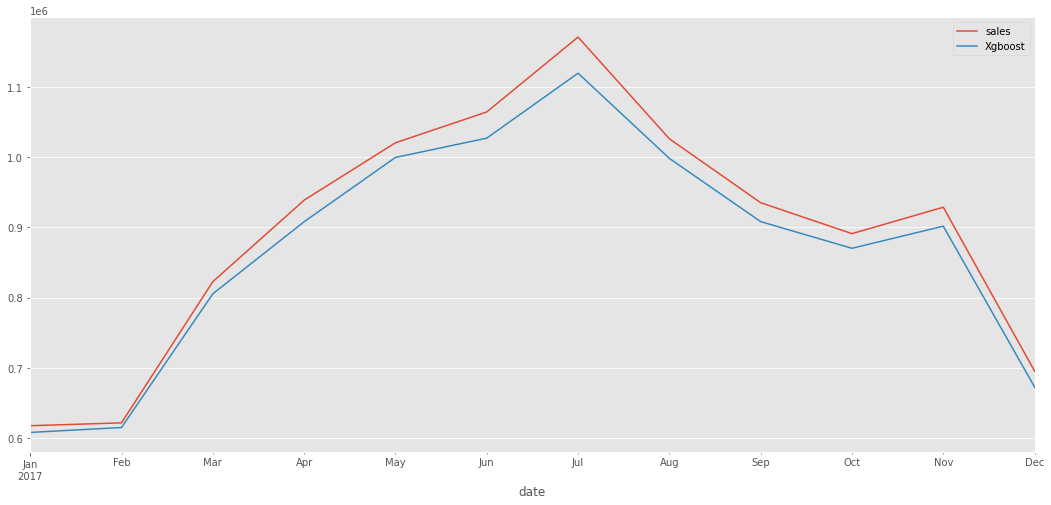

In [390]:
# plot_future(Xgboost, 'Xgboost', Xgboost_test_y)
result_xgboost=pd.concat([Xgboost_test_orig.reset_index(), pd.DataFrame(Xgboost, columns=['Xgboost'])], axis=1, ignore_index=False)
result_xgboost = result_xgboost.groupby(['date']).sum()
result_xgboost = result_xgboost.loc[:, ['sales', 'Xgboost']]
result_xgboost

result_xgboost.plot()

In [399]:
# train_data = salesbymonth_train.reset_index()
# test_data= salesbymonth_test.reset_index()

# 빠르게 테스트 해 보기 위해 월별로 아이템 판매 예측을 해 보기로 함
df2 = train.drop(['store', 'item'], axis=1)
df2 = df2.reset_index()
df2 = df2.groupby('date').sum()['sales']
df2 = df2.reset_index()

# 결측값 처리
# Check for missing values
print('Total num of missing values:') 
print(df2.sales.isna().sum())
print('')
# Locate the missing value
df_missing_date = df2.loc[df2.sales.isna() == True]
print('The date of missing value:')
print(df_missing_date.loc[:,['date']])
# Replcase missing value with interpolation
df2.sales.interpolate(inplace = True)
# Keep WC and drop Date
df2 = df2.drop('date', axis = 1)

Total num of missing values:
0

The date of missing value:
Empty DataFrame
Columns: [date]
Index: []


X_train.shape:  (1430, 30, 1)
y_train.shape:  (1430, 1)
X_test.shape:  (336, 30, 1)
y_test.shape:  (336, 1)
Epoch 1/100
72/72 [==============================] - 5s 41ms/step - loss: 0.0178 - accuracy: 0.0000e+00 - val_loss: 0.0726 - val_accuracy: 0.0000e+00
Epoch 2/100
72/72 [==============================] - 2s 32ms/step - loss: 0.0228 - accuracy: 0.0000e+00 - val_loss: 0.0788 - val_accuracy: 0.0000e+00
Epoch 3/100
72/72 [==============================] - 2s 32ms/step - loss: 0.0217 - accuracy: 0.0000e+00 - val_loss: 0.0290 - val_accuracy: 0.0035
Epoch 4/100
72/72 [==============================] - 2s 32ms/step - loss: 0.0146 - accuracy: 0.0000e+00 - val_loss: 0.0233 - val_accuracy: 0.0035
Epoch 5/100
72/72 [==============================] - 2s 32ms/step - loss: 0.0138 - accuracy: 0.0000e+00 - val_loss: 0.0265 - val_accuracy: 0.0035
Epoch 6/100
72/72 [==============================] - 2s 32ms/step - loss: 0.0137 - accuracy: 0.0000e+00 - val_loss: 0.0261 - val_accuracy: 0.0035
Epoch 7/

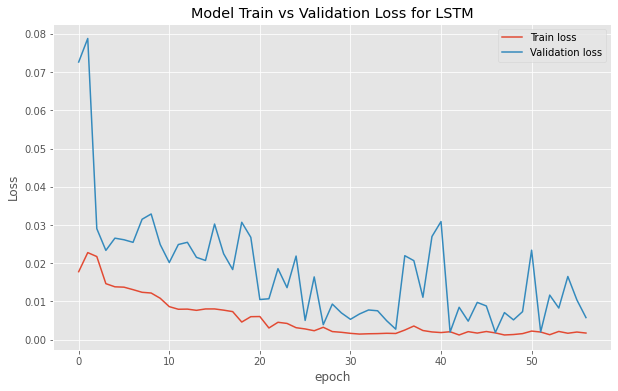

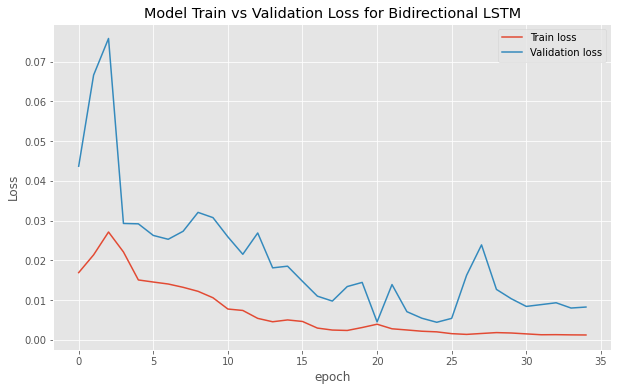

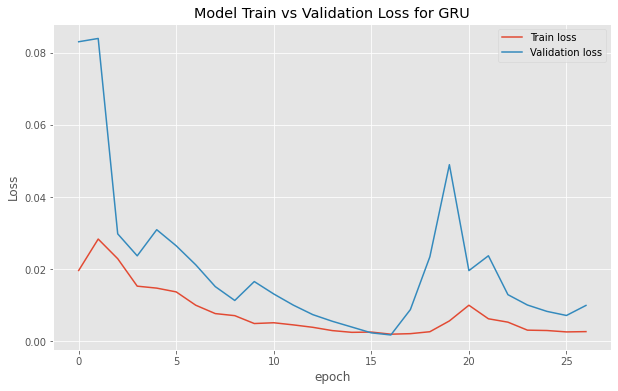

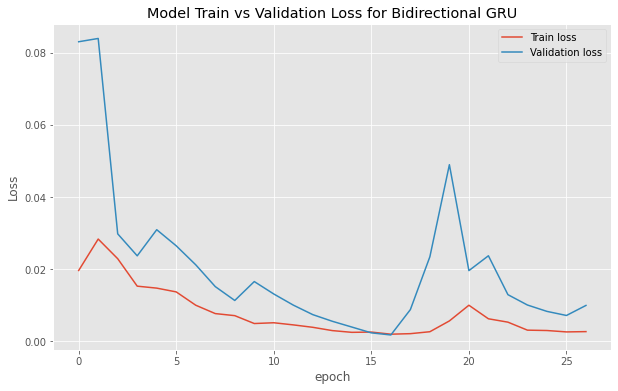

In [425]:
# Split train data and test data
train_size = int(len(df2)*0.8)

train_data = df2.iloc[:train_size]
test_data = df2.iloc[train_size:]

scaler = MinMaxScaler().fit(train_data)
train_scaled = scaler.transform(train_data)
test_scaled = scaler.transform(test_data)

# Create input train
def create_train (X, look_back = 1):
    Xs, ys = [], []
 
    for i in range(len(X)-look_back):
        v = X[i:i+look_back]
        Xs.append(v)
        ys.append(X[i+look_back])
 
    return np.array(Xs), np.array(ys)
LOOK_BACK = 30

X_train, y_train = create_train(train_scaled,LOOK_BACK)
X_test, y_test = create_train(test_scaled,LOOK_BACK)
# Print data shape
print('X_train.shape: ', X_train.shape)
print('y_train.shape: ', y_train.shape)
print('X_test.shape: ', X_test.shape) 
print('y_test.shape: ', y_test.shape)


# Create LSTM model
def create_lstm(units):
    # input shape에 전처리된 train_x의 형태를 넣는다
    # 20%로 Drop-out 했다
    model = keras.Sequential()
    model.add(keras.layers.LSTM(units = units,input_shape=(X_train.shape[1], X_train.shape[2])))
    # model.add(Dropout(0.2)) 
    # Hidden layer
    model.add(keras.layers.Dense(units=units))
    # model.add(Dropout(0.2)) 
    model.add(Dense(1))
    #Compile model
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
    return model

# Create BiLSTM model
def create_bilstm(units):
    model = Sequential()
    # Input layer
    model.add(Bidirectional(
              LSTM(units = units, return_sequences=True), 
              input_shape=(X_train.shape[1], X_train.shape[2])))
    # model.add(Dropout(0.2)) 
    # Hidden layer
    model.add(Bidirectional(LSTM(units = units)))
    # model.add(Dropout(0.2))
    model.add(Dense(1))
    #Compile model
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
    return model

# Create GRU model
def create_gru(units):
    model = Sequential()
    # Input layer
    model.add(GRU (units = units, return_sequences = True, 
    input_shape = [X_train.shape[1], X_train.shape[2]]))
    model.add(Dropout(0.2)) 
    # Hidden layer
    model.add(GRU(units = units)) 
    model.add(Dropout(0.2))
    model.add(Dense(units = 1)) 
    #Compile model
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
    return model

# Create BiGRU model
def create_bigru(units):
    model = Sequential()
    # Input layer
    model.add(Bidirectional(
        GRU (units = units, return_sequences = True), 
    input_shape = [X_train.shape[1], X_train.shape[2]]))
    model.add(Dropout(0.2)) 
    # Hidden layer
    model.add(GRU(units = units)) 
    model.add(Dropout(0.2))
    model.add(Dense(units = 1)) 
    #Compile model
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
    return model


def fit_model(model):
    early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                               patience = 10)
    history = model.fit(X_train, y_train, epochs = 100,  
                        validation_split = 0.2,
                        batch_size = 16, shuffle = False, 
                        callbacks = [early_stop])
    return history


def plot_loss (history, model_name):
    plt.figure(figsize = (10, 6))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Train vs Validation Loss for ' + model_name)
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend(['Train loss', 'Validation loss'], loc='upper right')


# Make prediction
def prediction(model):
    prediction = model.predict(X_test)
    return prediction

# Plot test data vs prediction
def plot_future(prediction, model_name, y_test):
    prediction = scaler.inverse_transform(prediction)
    plt.figure(figsize=(18, 8))
    range_future = len(prediction)
    plt.plot(np.arange(range_future), np.array(y_test), 
             label='Test data')
    plt.plot(np.arange(range_future), 
             np.array(prediction),label='Prediction')
    plt.title('Test data vs prediction for ' + model_name)
    plt.legend(loc='upper left')
    plt.xlabel('Time (day)')
    plt.ylabel('Counts')

model_lstm = create_lstm(128)
model_bilstm = create_bilstm(128)
model_gru = create_gru(128)
model_bigru = create_bilstm(128)

history_lstm = fit_model(model_lstm)
history_bilstm = fit_model(model_bilstm)
history_gru = fit_model(model_gru)
history_bigru = fit_model(model_bigru)

y_test = scaler.inverse_transform(y_test)
y_train = scaler.inverse_transform(y_train)

plot_loss (history_lstm, 'LSTM')
plot_loss (history_bilstm, 'Bidirectional LSTM')
plot_loss (history_gru, 'GRU')
plot_loss (history_gru, 'Bidirectional GRU')

In [413]:
prediction_lstm = prediction(model_lstm)
prediction_bilstm = prediction(model_bilstm)
prediction_gru = prediction(model_gru)
prediction_bigru = prediction(model_bigru)

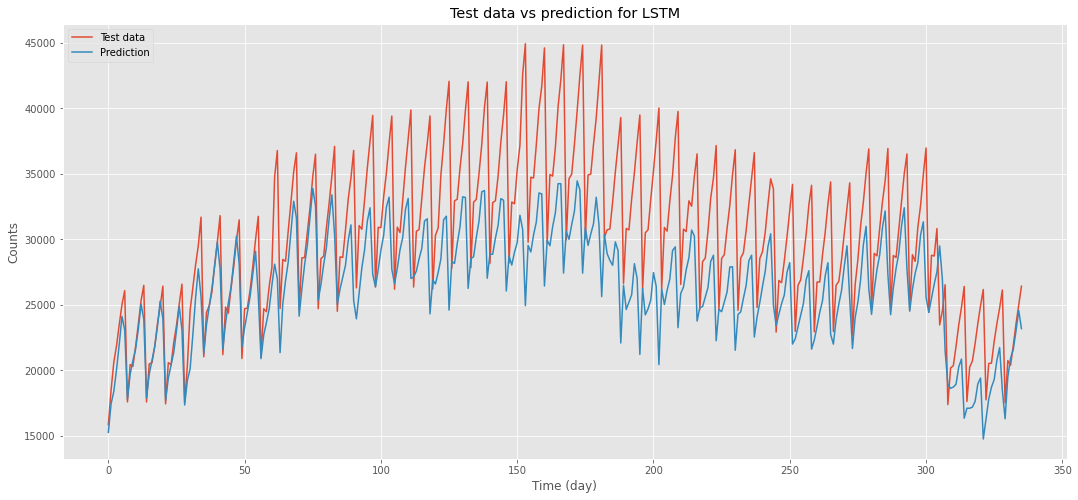

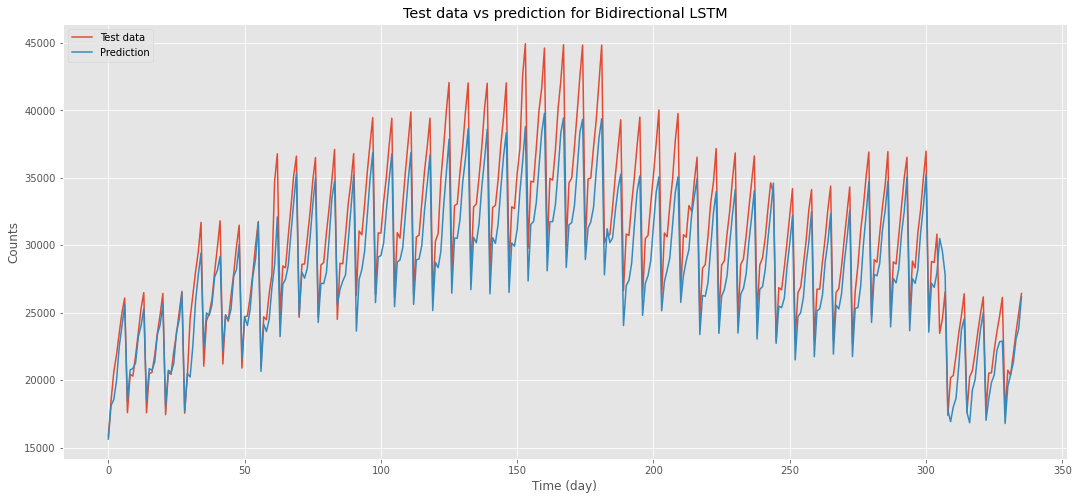

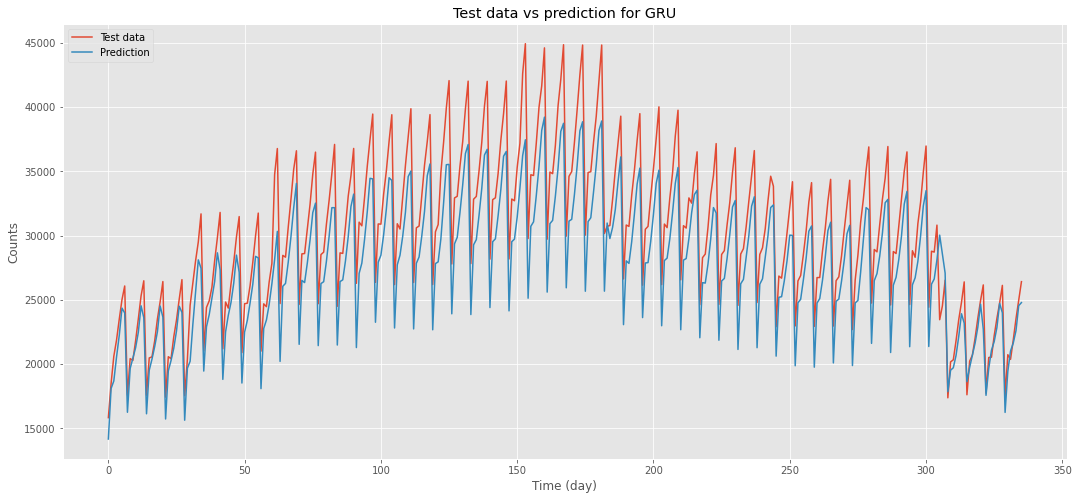

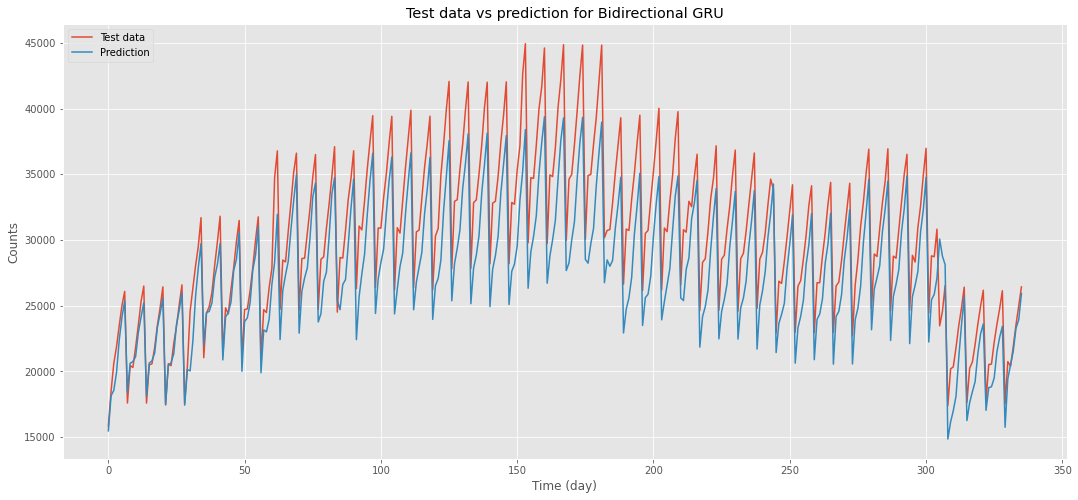

In [414]:
plot_future(prediction_lstm, 'LSTM', y_test)
plot_future(prediction_bilstm, 'Bidirectional LSTM', y_test)
plot_future(prediction_gru, 'GRU', y_test)
plot_future(prediction_bigru, 'Bidirectional GRU', y_test)

In [426]:
def evaluate_prediction(actual, predictions, model_name):
    print(model_name + ':')
    print('r2_score: {:.4f}'.format(r2_score(actual, predictions)))
    print('Mean Absolute Error: {:.4f}'.format(mean_absolute_error(actual, predictions)))
    print('MSE: {:.4f}'.format(mean_squared_error(actual, predictions)))
    print('Root Mean Square Error: {:.4f}'.format(np.sqrt(mean_absolute_error(actual, predictions))))
    print('RMSLE: {:.4f}'.format(np.sqrt(mean_squared_error(actual, predictions))))
    print('')

def evaluate_prediction2(predictions, actual, model_name):
    errors = predictions - actual
    mse = np.square(errors).mean()
    mae = np.abs(errors).mean()
    rmsle = np.sqrt(mse)
    rmse = np.sqrt(mae)

    print(model_name + ':')
    print('Mean Absolute Error: {:.4f}'.format(mae))
    print('MSE: {:.4f}'.format(mse))
    print('Root Mean Square Error: {:.4f}'.format(rmse))
    print('RMSLE: {:.4f}'.format(rmsle))
    print('')


evaluate_prediction(salesbymonth_test_final['sales'], salesbymonth_test_final['SeasonalARIMA'], 'ARIMA')
evaluate_prediction(result_xgboost['sales'], result_xgboost['Xgboost'], 'XGboost')

evaluate_prediction2(prediction_lstm, y_test, 'LSTM')
evaluate_prediction2(prediction_bilstm, y_test, 'Bidirectiona LSTM')
evaluate_prediction2(prediction_gru, y_test, 'GRU')
evaluate_prediction2(prediction_bigru, y_test, 'Bidirectiona GRU')

ARIMA:
r2_score: 0.9915
Mean Absolute Error: 12190.8863
MSE: 240951261.2481
Root Mean Square Error: 110.4123
RMSLE: 15522.6048

XGboost:
r2_score: 0.9734
Mean Absolute Error: 24963.1458
MSE: 754579990.2773
Root Mean Square Error: 157.9973
RMSLE: 27469.6194

LSTM:
Mean Absolute Error: 30210.1332
MSE: 949940172.7868
Root Mean Square Error: 173.8106
RMSLE: 30821.0995

Bidirectiona LSTM:
Mean Absolute Error: 30210.0716
MSE: 949935672.5150
Root Mean Square Error: 173.8104
RMSLE: 30821.0265

GRU:
Mean Absolute Error: 30210.0927
MSE: 949936933.2162
Root Mean Square Error: 173.8105
RMSLE: 30821.0469

Bidirectiona GRU:
Mean Absolute Error: 30210.0964
MSE: 949937198.9920
Root Mean Square Error: 173.8105
RMSLE: 30821.0512



In [ ]:
# testA_data_final['SeasonalARIMA'] = SARIMA_predict_day_1
# testA_data_final.plot()
# result_xgboost.plot()

plot_future(prediction_lstm, 'LSTM', y_test)
plot_future(prediction_bilstm, 'Bidirectional LSTM', y_test)
plot_future(prediction_gru, 'GRU', y_test)
plot_future(prediction_bigru, 'Bidirectional GRU', y_test)

ValueError: ignored

In [ ]:
from tensorflow.keras import load_model
model.save('mnist_mlp_model.h5')